# Simulation

[[1]](https://github.com/eitcom/pyEIT)

In [1]:
# coding: utf-8
""" demo on forward 2D """
# Copyright (c) Benyuan Liu. All Rights Reserved.
# Distributed under the (new) BSD License. See LICENSE.txt for more info.
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
import numpy as np
import pyeit.eit.protocol as protocol
import pyeit.mesh as mesh
from pyeit.eit.fem import EITForward, Forward
from pyeit.eit.interp2d import pdegrad, sim2pts
from pyeit.mesh.shape import thorax
from pyeit.mesh.wrapper import PyEITAnomaly_Circle
import os

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from src.util import (plot_mesh, createTrajectory, create2DAnimation, define_mesh_obj, plot_mesh_permarray)

## Erstellung der Simulationsdaten

In [2]:
""" 0. build mesh """
n_el = 32
mesh_obj = mesh.create(n_el, h0=0.05)
el_pos = mesh_obj.el_pos 
mesh_obj.print_stats()                     
protocol_obj = protocol.create(n_el, dist_exc=n_el//2, step_meas=1, parser_meas="meas_current")   

def calculateData(mesh):
    ex_line = protocol_obj.ex_mat[0].ravel() 
    fwd = Forward(mesh)
    f = fwd.solve(ex_line)  
    fwd = EITForward(mesh_obj, protocol_obj)
    f= np.real(f) 
    v = fwd.solve_eit(perm=mesh.perm)   
    return (f, v)


def createAnomaly(traj, Nsteps, r, r_path, r_path_variations, bound, added_noise):

    # Erzeuge die Trajektorie
    center_pos = createTrajectory(traj, r_path, r_path_variations, bound, num_points=Nsteps)
    
    mesh_new_list = []
    perm = 0.9
    for center in center_pos:
        anomaly = PyEITAnomaly_Circle(center, r=r,  perm=perm)
        anomaly_mesh = mesh.set_perm(mesh_obj, anomaly=anomaly, background=0.1)

        if added_noise:
            anomaly_mesh.perm = anomaly_mesh.perm  + np.random.normal(scale=0.05, size=anomaly_mesh.perm_array.shape[0])

        f, v = calculateData(anomaly_mesh)

        mesh_dict = {
            "mesh": anomaly_mesh,
            "x": center[0],
            "y": center[1],
            "radius": r,
            "perm_init": perm,
            "f": f,
            "v": v,
            "anomaly": anomaly,
        }
        mesh_new_list.append(mesh_dict)

    return mesh_new_list

2D mesh status:
1486 nodes, 2840 elements


## Erstellt Plot der Trajektorie

In [3]:
def checkTraj(mesh_new_list, Nstep):
    plt.figure(figsize=(10, 10))
    
    pts = mesh_new_list[0]["mesh"].node
    tri = mesh_new_list[0]["mesh"].element
    
    plt.triplot(pts[:, 0], pts[:, 1], tri, color='gray', alpha=0.5)
    
    x_coords = [mesh_dict["x"] for mesh_dict in mesh_new_list]
    y_coords = [mesh_dict["y"] for mesh_dict in mesh_new_list]
    
    plt.plot(x_coords, y_coords, '-', color='blue', alpha=0.6, 
             label='Trajektorie', linewidth=2)
    
    num_images = Nstep
    step_size = max(Nstep // num_images, 1)  

    indices = np.linspace(0, Nstep - 1, num_images, dtype=int)

    for i in indices:
        plt.plot(x_coords[i], y_coords[i], 'ro', markersize=6)
        
        circle = Circle((x_coords[i], y_coords[i]), 
                       radius=mesh_new_list[i]["radius"],
                       fill=False, 
                       color='red',
                       alpha=0.3)
        plt.gca().add_patch(circle)
    
    if hasattr(mesh_new_list[0]["mesh"], 'el_pos'):
        el_pos = mesh_new_list[0]["mesh"].el_pos
        plt.plot(pts[el_pos, 0], pts[el_pos, 1], 'ko', 
                markersize=6, label='Elektroden')
    
    plt.axis('equal')
    
    plt.xlabel('X-Koordinate')
    plt.ylabel('Y-Koordinate')
    plt.title('EIT Mesh mit Anomalie-Trajektorie')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()
    

def plotMesh(mesh_new_list):

    for i in range(2):
        plot_mesh(mesh_new_list[i]["mesh"])

## Ruft Funktionen auf und speichert Simulationsdaten

In [4]:
def generateData (traj,Nstep,r_anomaly,r_path, r_path_variations, bound, added_noise, saveData,createGif):
    
    mesh_new_list = createAnomaly(traj, Nstep, r_anomaly, r_path, r_path_variations, bound, added_noise)
    if saveData: 
        
        base_dataset_folder = "data_set"
        os.makedirs(base_dataset_folder, exist_ok=True)

        base_name = "data"

        counter = 1
        folder_name = os.path.join(base_dataset_folder, base_name)
        
        
        while os.path.exists(folder_name):
            
            folder_name = os.path.join(base_dataset_folder, f"{base_name}{counter}")
            
            counter += 1
        os.makedirs(folder_name) 

        lookup = {
                "folder": folder_name,
                "Trajectory": traj,
                "Nstep": Nstep,
                "r_anomaly": r_anomaly,
                "r_path": r_path,
                "r_path_variations": r_path_variations,
                "added_noise": added_noise
        }
        lookup_file_path = os.path.join(base_dataset_folder, "parameter_log.txt")
        
        with open(lookup_file_path, 'a') as f:
            f.write(f"Folder: {folder_name}\n")
            f.write(f"Trajectory: {traj}\n")
            f.write(f"Nstep: {Nstep}\n")
            f.write(f"r_anomaly: {r_anomaly}\n")
            f.write(f"r_path: {r_path}\n")
            f.write(f"r_path_variantions: {r_path_variations}\n")
            f.write(f"bound: {bound} \n")
            f.write(f"added_noise: {added_noise}\n")
            f.write("-" * 40 + "\n")  # Trennlinie zwischen Einträgen    
      

        for i in range(len(mesh_new_list)):
            file_path = os.path.join(folder_name, f"sample_{i:06d}.npz")  
            np.savez(file_path, v=mesh_new_list[i]["v"], anomaly=mesh_new_list[i]["anomaly"], gamma = mesh_new_list[i]["mesh"].perm)

    if createGif==True:
        create2DAnimation(traj,mesh_new_list,protocol_obj,mesh_obj)  

    #plotMesh(mesh_new_list)

    checkTraj(mesh_new_list,Nstep)

    return mesh_new_list

## Hier kann Simulation ausgeführt und Parameter angepasst werden

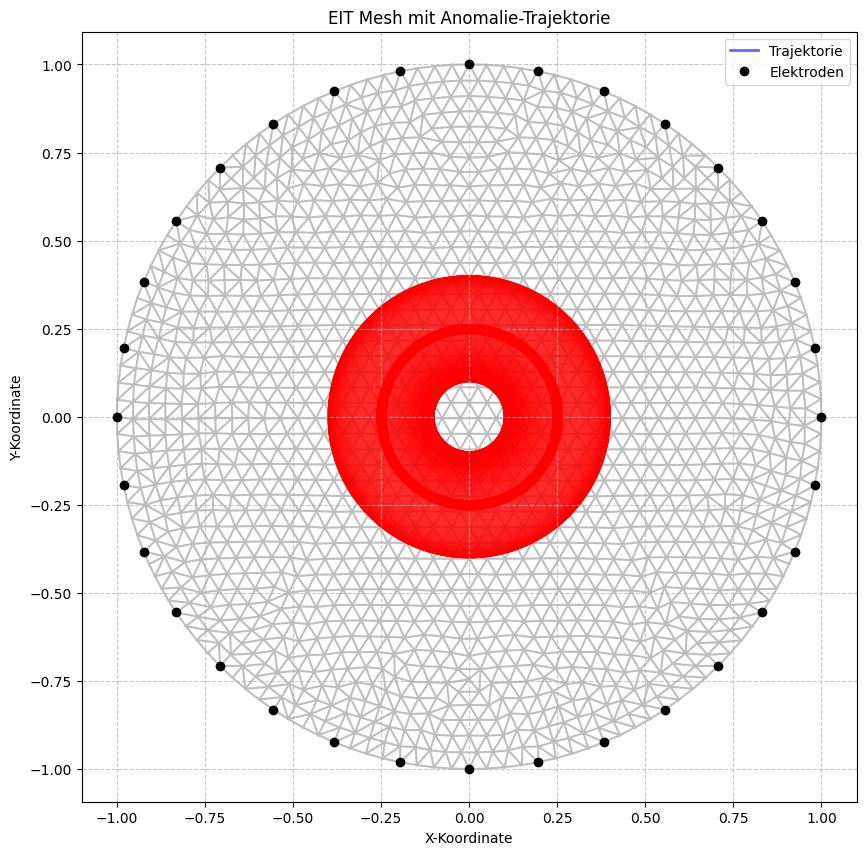

In [22]:
Nstep = 1000                  # Anzahl der Steps bzw. Punkte auf der Trajektorie
r_anomaly = 0.15                  # Radius der Anomaly

r_path = 0.25                    # Radius der Kreisbahn 
traj = "Kreis"
saveData = True
createGif = False

r_path_variations = False
bound = 0.1
added_noise = True

mesh_new_list = generateData(traj, Nstep, r_anomaly, r_path, r_path_variations, bound, added_noise, saveData,createGif)